# Final Project Checkpoint 1

**Travis Tegen - Coursera MSCS 6300** </br>

In [1]:
""" RUN THIS CELL TO GET THE RIGHT FORMATTING """
import requests
from IPython.core.display import HTML
css_file = 'https://raw.githubusercontent.com/bsethwalker/clemson-cs4300/main/css/cpsc6300.css'
styles = requests.get(css_file).text
HTML(styles)

In [2]:
%matplotlib inline
import numpy as np
import scipy as sp
import matplotlib.pyplot as plt
import pandas as pd
from pandas.plotting import scatter_matrix

import statsmodels.api as sm
from statsmodels.api import OLS

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import PolynomialFeatures
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Ridge
from sklearn.linear_model import Lasso
from sklearn.metrics import r2_score
from sklearn.metrics import accuracy_score
from sklearn.metrics import roc_curve
from sklearn.metrics import auc
from matplotcheck.base import PlotTester
from matplotlib.patches import PathPatch

In [3]:
pbd_df = pd.read_csv("pbd-cleaned.csv")
pbd_df = pbd_df.drop(['Cherry blossom festival start date', 'Cherry blossom festival duration'], axis=1)
pbd_df.rename(columns={"Year": "year", "Yoshino peak bloom date": "pbd"}, inplace=True)
pbd_df.head()
# pbd_df.describe()

,year,pbd
0,1921,79
1,1922,97
2,1923,99
3,1924,104
4,1925,86


pbd_df will be the starting point and main df that has everything we want at the end. we'll add things to it sequentially until it has what we want.

In [4]:
# next we want avg_temp_dec, avg_temp_jan, avg_temp_feb, avg_temp_mar
avg_temp_df = pd.read_csv("weather-avg-temp.csv")
avg_temp_df.rename(columns={"Year": "year"}, inplace=True)
avg_temp_df.head()
# temp_df.describe()

,year,Jan,Feb,Mar,Apr,May,Jun,Jul,Aug,Sep,Oct,Nov,Dec,Annual
0,1920,28.7,32.7,45.5,52.7,60.0,71.6,75.0,74.9,68.8,61.2,45.9,39.3,54.7
1,1921,36.6,39.0,55.5,59.1,62.3,74.2,79.3,72.7,74.4,57.0,47.5,37.9,58.0
2,1922,31.9,38.7,45.3,55.6,66.9,74.5,76.6,73.1,69.9,59.4,47.9,37.6,56.5
3,1923,36.8,32.6,45.3,53.6,63.4,75.6,75.7,74.4,69.7,56.1,45.1,45.0,56.1
4,1924,35.0,34.3,42.6,51.9,60.0,71.3,75.0,74.8,64.3,57.5,46.0,36.5,54.1


In [5]:
# start with avg_temp_dec because that is the hardest to get since we 
# have to go into the previous row to get it
avg_temp_df_shifted = avg_temp_df.copy()
avg_temp_df_shifted['year'] = avg_temp_df_shifted['year'] + 1
merged_df = pd.merge(pbd_df, avg_temp_df_shifted, on='year', how='left')
pbd_df['avg_tmp_prevdec'] = merged_df['Dec']
pbd_df.head()

,year,pbd,avg_tmp_prevdec
0,1921,79,39.3
1,1922,97,37.9
2,1923,99,37.6
3,1924,104,45.0
4,1925,86,36.5


In [6]:
# now add in the avg_tmp_jan thru mar columns
merged_df = pd.merge(pbd_df, avg_temp_df, on='year', how='left')
pbd_df['avg_tmp_jan'] = merged_df['Jan']
pbd_df['avg_tmp_feb'] = merged_df['Feb']
pbd_df['avg_tmp_mar'] = merged_df['Mar']
pbd_df.head()

,year,pbd,avg_tmp_prevdec,avg_tmp_jan,avg_tmp_feb,avg_tmp_mar
0,1921,79,39.3,36.6,39.0,55.5
1,1922,97,37.9,31.9,38.7,45.3
2,1923,99,37.6,36.8,32.6,45.3
3,1924,104,45.0,35.0,34.3,42.6
4,1925,86,36.5,32.9,43.1,46.4


In [7]:
# next we want avg_temp_dec, avg_temp_jan, avg_temp_feb, avg_temp_mar
precip_df = pd.read_csv("weather-precip.csv")
precip_df.rename(columns={"Year": "year"}, inplace=True)
precip_df.head()
precip_df.describe()

# do "prevdec" first like we did with temperature
precip_df_shifted = precip_df.copy()
precip_df_shifted['year'] = precip_df_shifted['year'] + 1
merged_df = pd.merge(pbd_df, precip_df_shifted, on='year', how='left')
pbd_df['precip_prevdec'] = merged_df['Dec']

# followed by jan - mar...
merged_df = pd.merge(pbd_df, precip_df, on='year', how='left')
pbd_df['precip_jan'] = merged_df['Jan']
pbd_df['precip_feb'] = merged_df['Feb']
pbd_df['precip_mar'] = merged_df['Mar']
pbd_df.head()

,year,pbd,avg_tmp_prevdec,avg_tmp_jan,avg_tmp_feb,avg_tmp_mar,precip_prevdec,precip_jan,precip_feb,precip_mar
0,1921,79,39.3,36.6,39.0,55.5,3.15,2.30,2.29,2.76
1,1922,97,37.9,31.9,38.7,45.3,1.95,5.56,2.86,4.74
2,1923,99,37.6,36.8,32.6,45.3,3.48,4.24,2.19,4.47
3,1924,104,45.0,35.0,34.3,42.6,2.80,3.21,3.05,6.17
4,1925,86,36.5,32.9,43.1,46.4,2.98,4.44,0.98,1.60


In [8]:
# next, need to add the columns for snowfall

# read in and cleanup snowfall data: make each row be year, prevDec, Jan-Mar
snow_df = pd.read_csv("weather-snow.csv")
snow_df.rename(columns={"Year": "year", 'Dec': 'prevdec'}, inplace=True)
snow_df = snow_df.drop(['Jul','Aug','Sep','Oct','Nov','Apr','May','June','Season'], axis=1)
# 1920-1921 -> 1921
snow_df['year'] = snow_df['year'].str.split('-').str[1].astype(int)
# replace T's (stands for trace amount) with 0.05
for col in snow_df.columns:
    snow_df[col] = snow_df[col].replace('T', 0.05)

snow_df.head()
# snow_df.describe()


,year,prevdec,Jan,Feb,Mar
0,1921,0.2,1.8,7.1,0.05
1,1922,5.5,31.5,3,6.5
2,1923,1.8,3.1,3.9,6.7
3,1924,1.7,1,5.3,9.3
4,1925,0.5,19.7,0.05,0.05


In [9]:
# now add in the 4 snow columns. conveniently prevdec is already there.
merged_df = pd.merge(pbd_df, snow_df, on='year', how='left')
pbd_df['snow_prevdec'] = merged_df['prevdec']
pbd_df['snow_jan'] = merged_df['Jan']
pbd_df['snow_feb'] = merged_df['Feb']
pbd_df['snow_mar'] = merged_df['Mar']
pbd_df.head()

,year,pbd,avg_tmp_prevdec,avg_tmp_jan,avg_tmp_feb,avg_tmp_mar,precip_prevdec,precip_jan,precip_feb,precip_mar,snow_prevdec,snow_jan,snow_feb,snow_mar
0,1921,79,39.3,36.6,39.0,55.5,3.15,2.30,2.29,2.76,0.2,1.8,7.1,0.05
1,1922,97,37.9,31.9,38.7,45.3,1.95,5.56,2.86,4.74,5.5,31.5,3,6.5
2,1923,99,37.6,36.8,32.6,45.3,3.48,4.24,2.19,4.47,1.8,3.1,3.9,6.7
3,1924,104,45.0,35.0,34.3,42.6,2.80,3.21,3.05,6.17,1.7,1,5.3,9.3
4,1925,86,36.5,32.9,43.1,46.4,2.98,4.44,0.98,1.60,0.5,19.7,0.05,0.05


In [10]:
# we only need the frost column now

# read in the frost data
frost_df = pd.read_csv("weather-frost.csv")
frost_df = frost_df.drop(['Last Frost'], axis=1)
frost_df.rename(columns={"Year": "year"}, inplace=True)
# Nov-12(1920) -> Nov-12
frost_df['First Frost'] = frost_df['First Frost'].str.split('(').str[0].astype(str)

# we'll need a prevfrost column like we did for prevdec
frost_df_shifted = frost_df.copy()
frost_df_shifted['year'] = frost_df_shifted['year'] + 1
merged_df = pd.merge(frost_df, frost_df_shifted, on='year', how='left')
frost_df['prevfrost'] = merged_df['First Frost_y']
frost_df = frost_df.drop(['First Frost'], axis=1)
frost_df = frost_df.iloc[1:]
frost_df = frost_df.reset_index(drop=True)

# now we have year and prevfrost, but need to create a frostdaysbefore to be # of days before Jan-1
# run some logic on the prevfrost column to calculate the # of days between it and Jan 1
from datetime import datetime
def days_to_jan1(row):
    frost_date_str = row['prevfrost']
    year = row['year']

    # Parse the frost date string
    frost_month_str, frost_day_str = frost_date_str.split('-')
    frost_month = datetime.strptime(frost_month_str, '%b').month
    frost_day = int(frost_day_str)

    frost_date = datetime(year, frost_month, frost_day)
    jan1_date = datetime(year + 1, 1, 1)

    return (jan1_date - frost_date).days
frost_df['frostdaysbefore'] = frost_df.apply(days_to_jan1, axis=1)

# now add the calculated column to the main df and name it a little better
merged_df = pd.merge(pbd_df, frost_df, on='year', how='left')
pbd_df['first_frost_to_jan1'] = merged_df['frostdaysbefore']
pbd_df.head()

,year,pbd,avg_tmp_prevdec,avg_tmp_jan,avg_tmp_feb,avg_tmp_mar,precip_prevdec,precip_jan,precip_feb,precip_mar,snow_prevdec,snow_jan,snow_feb,snow_mar,first_frost_to_jan1
0,1921,79,39.3,36.6,39.0,55.5,3.15,2.30,2.29,2.76,0.2,1.8,7.1,0.05,50
1,1922,97,37.9,31.9,38.7,45.3,1.95,5.56,2.86,4.74,5.5,31.5,3,6.5,52
2,1923,99,37.6,36.8,32.6,45.3,3.48,4.24,2.19,4.47,1.8,3.1,3.9,6.7,40
3,1924,104,45.0,35.0,34.3,42.6,2.80,3.21,3.05,6.17,1.7,1,5.3,9.3,60
4,1925,86,36.5,32.9,43.1,46.4,2.98,4.44,0.98,1.60,0.5,19.7,0.05,0.05,46


# Visualizations

Visualizing the relationship of some predictor variables I think might influence the response:

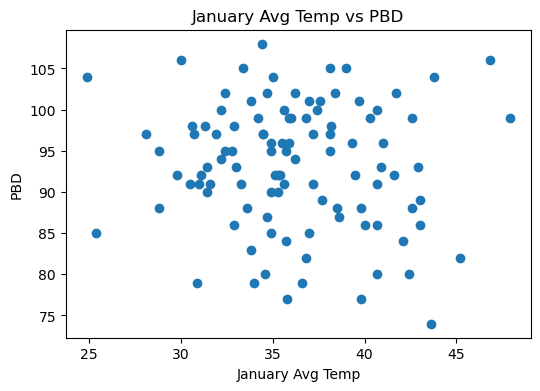

In [11]:
# make a scatter plot of pbd on the y axis and jan avg tmp on x axis
fig, ax = plt.subplots(figsize=(6, 4))
scatter = ax.scatter(pbd_df['avg_tmp_jan'], pbd_df['pbd'])
ax.set_title('January Avg Temp vs PBD')
ax.set_xlabel('January Avg Temp')
ax.set_ylabel('PBD')
plt.show()

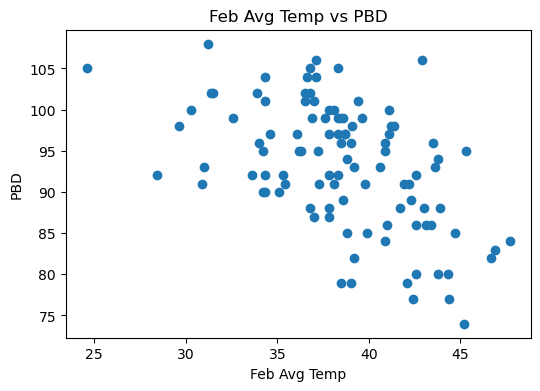

In [12]:
# now do Feb Avg Tmp vs PBD
fig, ax = plt.subplots(figsize=(6, 4))
scatter = ax.scatter(pbd_df['avg_tmp_feb'], pbd_df['pbd'])
ax.set_title('Feb Avg Temp vs PBD')
ax.set_xlabel('Feb Avg Temp')
ax.set_ylabel('PBD')
plt.show()

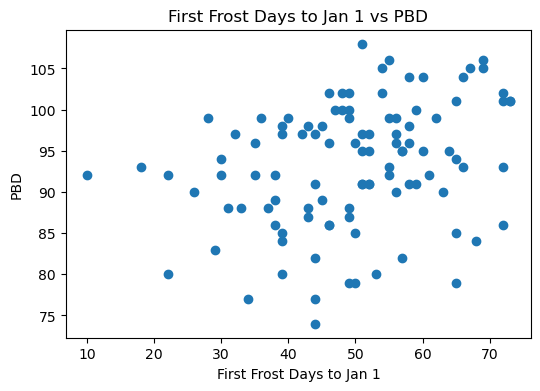

In [13]:
# now do First Frost Days To Jan 1 vs PBD
fig, ax = plt.subplots(figsize=(6, 4))
scatter = ax.scatter(pbd_df['first_frost_to_jan1'], pbd_df['pbd'])
ax.set_title('First Frost Days to Jan 1 vs PBD')
ax.set_xlabel('First Frost Days to Jan 1')
ax.set_ylabel('PBD')
plt.show()